Step 1: Importing and cleaning merchants.csv dataset.

Step 2: Importing and cleaning historical_transactions.parquet dataset

Step 3: Perform the tasks

In [0]:
# IMPORT LIBRARIES
from pyspark.sql.types import DoubleType
from pyspark.sql import Row
from pyspark.sql.functions import col, date_format, when, sum as spark_sum, count as spark_count, avg as spark_avg, desc, hour, to_timestamp, lit, round
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import pandas as pd
import matplotlib.pyplot as plt

## Step 1 - Importing and cleaning merchants.csv dataset.

In [0]:
# File location and type
file_location = "/FileStore/tables/merchants_subset-4.csv"

# Read file
merchants = spark.read.csv(file_location, header=True, inferSchema=True)

In [0]:
merchants.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_group_id: integer (nullable = true)
 |-- merchant_category_id: integer (nullable = true)
 |-- subsector_id: integer (nullable = true)
 |-- numerical_1: double (nullable = true)
 |-- numerical_2: double (nullable = true)
 |-- most_recent_sales_range: string (nullable = true)
 |-- most_recent_purchases_range: string (nullable = true)
 |-- avg_sales_lag3: double (nullable = true)
 |-- avg_purchases_lag3: string (nullable = true)
 |-- active_months_lag3: integer (nullable = true)
 |-- avg_sales_lag6: double (nullable = true)
 |-- avg_purchases_lag6: string (nullable = true)
 |-- active_months_lag6: integer (nullable = true)
 |-- avg_sales_lag12: double (nullable = true)
 |-- avg_purchases_lag12: string (nullable = true)
 |-- active_months_lag12: integer (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- state_id: integer (nullable = true)



Some columns for which we expect to be numerical are interpreted as string, namely: avg_purchases_lag3, avg_purchases_lag6, avg_purchases_lag12.
Let's examine these columns closer to see why spart interpreted them as string, convert them to numerical and fix the potential issue

In [0]:
merchants.select('avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12').show(5)

+------------------+------------------+-------------------+
|avg_purchases_lag3|avg_purchases_lag6|avg_purchases_lag12|
+------------------+------------------+-------------------+
|        9.66666667|       18.66666667|        13.91666667|
|              1.75|        1.29166667|             1.6875|
|             260.0|             260.0|              260.0|
|        1.66666667|        4.66666667|         3.83333333|
|               0.5|        0.36111111|         0.34722222|
+------------------+------------------+-------------------+
only showing top 5 rows



In [0]:
# Convert 'string_column' to DoubleType
merchants = merchants.withColumn("avg_purchases_lag3",merchants.avg_purchases_lag3.cast('double'))
merchants = merchants.withColumn("avg_purchases_lag6",merchants.avg_purchases_lag6.cast('double'))
merchants = merchants.withColumn("avg_purchases_lag12",merchants.avg_purchases_lag12.cast('double'))

In [0]:
merchants.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_group_id: integer (nullable = true)
 |-- merchant_category_id: integer (nullable = true)
 |-- subsector_id: integer (nullable = true)
 |-- numerical_1: double (nullable = true)
 |-- numerical_2: double (nullable = true)
 |-- most_recent_sales_range: string (nullable = true)
 |-- most_recent_purchases_range: string (nullable = true)
 |-- avg_sales_lag3: double (nullable = true)
 |-- avg_purchases_lag3: double (nullable = true)
 |-- active_months_lag3: integer (nullable = true)
 |-- avg_sales_lag6: double (nullable = true)
 |-- avg_purchases_lag6: double (nullable = true)
 |-- active_months_lag6: integer (nullable = true)
 |-- avg_sales_lag12: double (nullable = true)
 |-- avg_purchases_lag12: double (nullable = true)
 |-- active_months_lag12: integer (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- state_id: integer (nullable = true)



## Step 2 - Importing and cleaning historical_transactions.parquet dataset

In [0]:
# File location and type
file_location = "/FileStore/tables/historical_transactions_subset-1.parquet"

# Read file
historical_transactions = spark.read.parquet(file_location, header=True, inferSchema=True)

In [0]:
historical_transactions.printSchema()

root
 |-- authorized_flag: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- installments: long (nullable = true)
 |-- category: string (nullable = true)
 |-- merchant_category_id: long (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- month_lag: long (nullable = true)
 |-- purchase_date: string (nullable = true)
 |-- state_id: long (nullable = true)
 |-- subsector_id: long (nullable = true)
 |-- purchase_amount: double (nullable = true)



In [0]:
historical_transactions.select('authorized_flag', 'customer_id', 'city_id', 'installments','category','merchant_category_id').show(10)
historical_transactions.select('merchant_id', 'month_lag','purchase_date','state_id','subsector_id','purchase_amount').show(10)

+---------------+---------------+-------+------------+--------+--------------------+
|authorized_flag|    customer_id|city_id|installments|category|merchant_category_id|
+---------------+---------------+-------+------------+--------+--------------------+
|              N|C_ID_2730b57487|     63|           3|       C|                 456|
|              Y|C_ID_95429da153|     38|           3|       C|                 884|
|              Y|C_ID_cdc7680c7f|    160|           1|       B|                 278|
|              N|C_ID_2858441b12|    291|           0|       A|                 360|
|              Y|C_ID_79d19b3395|    276|           1|       B|                 705|
|              Y|C_ID_cc549091ea|     17|           1|       B|                 454|
|              Y|C_ID_606e9a9a85|    212|           0|       A|                 705|
|              Y|C_ID_b3a219eaf6|     97|           1|       B|                 278|
|              Y|C_ID_ccf48edbb3|      2|           1|       B|  

In [0]:
from pyspark.sql.functions import to_timestamp

# Convert 'datetime_str' column to TimestampType
historical_transactions = historical_transactions.withColumn("purchase_date", to_timestamp("purchase_date", "yyyy-MM-dd HH:mm:ss"))

historical_transactions.select('purchase_date').show(10)
historical_transactions.printSchema()

+-------------------+
|      purchase_date|
+-------------------+
|2017-05-19 16:01:59|
|2017-12-07 22:33:34|
|2017-11-17 00:00:00|
|2017-09-07 02:16:40|
|2017-06-21 12:12:14|
|2017-12-09 16:48:07|
|2018-02-01 20:06:59|
|2017-11-30 15:57:59|
|2017-07-31 19:58:02|
|2017-12-08 11:07:19|
+-------------------+
only showing top 10 rows

root
 |-- authorized_flag: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- installments: long (nullable = true)
 |-- category: string (nullable = true)
 |-- merchant_category_id: long (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- month_lag: long (nullable = true)
 |-- purchase_date: timestamp (nullable = true)
 |-- state_id: long (nullable = true)
 |-- subsector_id: long (nullable = true)
 |-- purchase_amount: double (nullable = true)



## Task 1

In [0]:
# Select relevant columns for the task
task_1_df = historical_transactions.join(merchants, on="merchant_id", how="left").select(
    historical_transactions["purchase_date"],
    historical_transactions["city_id"],
    merchants["merchant_name"],
    historical_transactions["merchant_id"],
    historical_transactions["purchase_amount"])

task_1_df.show(5)

+-------------------+-------+--------------------+---------------+---------------+
|      purchase_date|city_id|       merchant_name|    merchant_id|purchase_amount|
+-------------------+-------+--------------------+---------------+---------------+
|2017-05-19 16:01:59|     63| Robert Chadwick inc|M_ID_fe83cec110|       18970.06|
|2017-12-07 22:33:34|     38| Dorothy Moore 4 inc|M_ID_9f11c207c1|       14904.52|
|2017-11-17 00:00:00|    160|     Eliz Prater inc|M_ID_ac78c7d82a|       21850.47|
|2017-09-07 02:16:40|    291|   Sandra Mcafee inc|M_ID_463d994b45|       18240.33|
|2017-06-21 12:12:14|    276|Ladonna Seelbach inc|M_ID_a3895ee34e|       10951.74|
+-------------------+-------+--------------------+---------------+---------------+
only showing top 5 rows



In [0]:
# in case merchant_name is missing, we populate it with merchant_id
task_1_df = task_1_df.withColumn(
    "merchant_name",
    when(col("merchant_name").isNull(), col("merchant_id")).otherwise(col("merchant_name"))
)

task_1_df.show(5)

+-------------------+-------+--------------------+---------------+---------------+
|      purchase_date|city_id|       merchant_name|    merchant_id|purchase_amount|
+-------------------+-------+--------------------+---------------+---------------+
|2017-05-19 16:01:59|     63| Robert Chadwick inc|M_ID_fe83cec110|       18970.06|
|2017-12-07 22:33:34|     38| Dorothy Moore 4 inc|M_ID_9f11c207c1|       14904.52|
|2017-11-17 00:00:00|    160|     Eliz Prater inc|M_ID_ac78c7d82a|       21850.47|
|2017-09-07 02:16:40|    291|   Sandra Mcafee inc|M_ID_463d994b45|       18240.33|
|2017-06-21 12:12:14|    276|Ladonna Seelbach inc|M_ID_a3895ee34e|       10951.74|
+-------------------+-------+--------------------+---------------+---------------+
only showing top 5 rows



In [0]:
# Extract month out of datetime column
task_1_df = task_1_df.withColumn(
    "Month",
    date_format(col("purchase_date"), "MMM-yyyy")
)
task_1_df.show(5)

+-------------------+-------+--------------------+---------------+---------------+--------+
|      purchase_date|city_id|       merchant_name|    merchant_id|purchase_amount|   Month|
+-------------------+-------+--------------------+---------------+---------------+--------+
|2017-05-19 16:01:59|     63| Robert Chadwick inc|M_ID_fe83cec110|       18970.06|May-2017|
|2017-12-07 22:33:34|     38| Dorothy Moore 4 inc|M_ID_9f11c207c1|       14904.52|Dec-2017|
|2017-11-17 00:00:00|    160|     Eliz Prater inc|M_ID_ac78c7d82a|       21850.47|Nov-2017|
|2017-09-07 02:16:40|    291|   Sandra Mcafee inc|M_ID_463d994b45|       18240.33|Sep-2017|
|2017-06-21 12:12:14|    276|Ladonna Seelbach inc|M_ID_a3895ee34e|       10951.74|Jun-2017|
+-------------------+-------+--------------------+---------------+---------------+--------+
only showing top 5 rows



In [0]:
# Calculate sum of purchase amounts and the number of transactions
task_1_df_grouped = task_1_df.groupBy("Month","city_id","merchant_name").agg(
    spark_sum("purchase_amount").alias("purchase_total"),
    spark_count("merchant_name").alias("no_of_sales") 
)
task_1_df_grouped.show(5)

+--------+-------+--------------------+------------------+-----------+
|   Month|city_id|       merchant_name|    purchase_total|no_of_sales|
+--------+-------+--------------------+------------------+-----------+
|Dec-2017|    174|   Vickie Marian inc|118701.68000000001|          6|
|Aug-2017|      4|   Jeanne Benton inc|105268.70000000001|          4|
|Jun-2017|     12|   Daniel Hopper inc|          34788.45|          2|
|Jul-2017|     53|Franklin Candelar...|1371646.6200000003|         63|
|May-2017|    157|      Alda Smith inc|          42833.34|          2|
+--------+-------+--------------------+------------------+-----------+
only showing top 5 rows



In [0]:
# Define the window specification
window_spec = Window.partitionBy("Month", "city_id").orderBy(col("purchase_total").desc())

# Add a rank column based on purchase_amount within each month and city
task_1_df_with_rank = task_1_df_grouped.withColumn("rank", rank().over(window_spec))
# Keep only top five observations
task_1_df_with_rank = task_1_df_with_rank.filter(col("rank") <= 5)
# Drop rank column
task_1_df_with_rank = task_1_df_with_rank.drop("rank")

task_1_df_with_rank.show()

+--------+-------+--------------------+--------------------+-----------+
|   Month|city_id|       merchant_name|      purchase_total|no_of_sales|
+--------+-------+--------------------+--------------------+-----------+
|Apr-2017|      1|  Kathie Sughrue inc|  6.64006056399999E7|       3301|
|Apr-2017|      1|      Cesar Hall inc| 6.190442570000003E7|       3065|
|Apr-2017|      1|     Mary Gray 7 inc|  3.63503779500002E7|       1818|
|Apr-2017|      1|  Steven Russell inc|2.2558267180000067E7|       1133|
|Apr-2017|      1|   Maxine Flores inc|1.8910550610000066E7|        933|
|Apr-2017|     13|     Carol Green inc|  488946.04999999993|         28|
|Apr-2017|     13|    Gary Koehler inc|           400706.62|         23|
|Apr-2017|     13|       Mark Bunn inc|            381646.1|         17|
|Apr-2017|     13|  Larry Brooks 2 inc|  256699.71999999997|         11|
|Apr-2017|     13|  Natalie Durate inc|  242325.99000000002|         13|
|Apr-2017|     21|   Thelma Cashen inc|          11

## Task 2

In [0]:
# Select relevant columns for the task
task_2_df = historical_transactions.join(merchants, on="merchant_id", how="left").select(
    historical_transactions["state_id"],
    merchants["merchant_name"],
    historical_transactions["merchant_id"],
    historical_transactions["purchase_amount"])

# in case merchant_name is missing, we populate it with merchant_id
task_2_df = task_2_df.withColumn(
    "merchant_name",
    when(col("merchant_name").isNull(), col("merchant_id")).otherwise(col("merchant_name"))
)

# Drop merchant_id column
task_2_df = task_2_df.drop("merchant_id")

task_2_df.show(5)

+--------+--------------------+---------------+
|state_id|       merchant_name|purchase_amount|
+--------+--------------------+---------------+
|       9| Robert Chadwick inc|       18970.06|
|       7| Dorothy Moore 4 inc|       14904.52|
|      21|     Eliz Prater inc|       21850.47|
|       9|   Sandra Mcafee inc|       18240.33|
|       9|Ladonna Seelbach inc|       10951.74|
+--------+--------------------+---------------+
only showing top 5 rows



In [0]:
# Calculate average purchase amount
task_2_df_grouped = task_2_df.groupBy("merchant_name","state_id").agg(
    spark_avg("purchase_amount").alias("average_amount")
)

task_2_df_grouped = task_2_df_grouped.orderBy(desc("average_amount"))

task_2_df_grouped.show()

+--------------------+--------+--------------+
|       merchant_name|state_id|average_amount|
+--------------------+--------+--------------+
|  Martha Tyrrell inc|       7|      39937.61|
|  Julie Mckelvey inc|       9|      39727.59|
|   Jennifer Pool inc|      24|      39658.71|
|    Ileana Owens inc|       9|      39649.56|
|  Robert Mullins inc|      15|      39642.69|
|Christopher Hamil...|      20|      39602.72|
|      Raul Creed inc|       2|      39569.62|
|    Samuel Evans inc|      15|       39558.6|
|  Dawn Ellington inc|      16|      39556.68|
|   Pamela Ulrich inc|      13|      39556.68|
| Mario Marroquin inc|       5|      39550.66|
|   Martha Meaney inc|      -1|      39541.64|
| Gertrude Leslie inc|       5|       39541.6|
|   Dorothy Zemel inc|      16|      39532.16|
|William Harris 2 inc|       4|       39531.7|
| Thomas Wright 3 inc|       7|      39502.42|
|     Anna Glover inc|       9|      39462.52|
|  Ashley Schmidt inc|       9|       39444.3|
|      Larry 

## Task 3

In [0]:
# Select relevant columns for the task
task_3_df = historical_transactions.select(
    historical_transactions["category"],
    historical_transactions["purchase_date"],
    historical_transactions["purchase_amount"])

# Create hour column
task_3_df_with_hour = task_3_df.withColumn("hour", hour(col("purchase_date")))

# Replace null categories with the text “Unknown category” where applicable
task_3_df_with_hour = task_3_df_with_hour.fillna({"category": "Unknown category"})

# Drop purchase_date column
task_3_df_with_hour = task_3_df_with_hour.drop("purchase_date")


task_3_df_with_hour.show(5)

+--------+---------------+----+
|category|purchase_amount|hour|
+--------+---------------+----+
|       C|       18970.06|  16|
|       C|       14904.52|  22|
|       B|       21850.47|   0|
|       A|       18240.33|   2|
|       B|       10951.74|  12|
+--------+---------------+----+
only showing top 5 rows



In [0]:
# Calculate sum of purchase amounts per each category and hour
task_3_df_grouped = task_3_df_with_hour.groupBy("category","hour").agg(
    spark_sum("purchase_amount").alias("purchase_total")
)

task_3_df_grouped = task_3_df_grouped.orderBy(desc("purchase_total"))

task_3_df_grouped.show(5)

+--------+----+--------------------+
|category|hour|      purchase_total|
+--------+----+--------------------+
|       A|  12| 5.731975337461182E9|
|       A|  13| 5.648608300811396E9|
|       A|  17| 5.473251727351727E9|
|       A|  18| 5.434835255351855E9|
|       A|  15|5.4141784121018915E9|
+--------+----+--------------------+
only showing top 5 rows



In [0]:
# Define the window specification
window_spec = Window.partitionBy("category").orderBy(col("purchase_total").desc())

# Add a rank column based on purchase_total within each hor
task_3_df_with_rank = task_3_df_grouped.withColumn("rank", rank().over(window_spec))
# Keep only top five observations
task_3_df_with_rank = task_3_df_with_rank.filter(col("rank") <= 3)

# Drop rank and purchase_total columns
task_3_df_with_rank = task_3_df_with_rank.drop("rank")
task_3_df_with_rank = task_3_df_with_rank.drop("purchase_total")

task_3_df_with_rank.show()

+----------------+----+
|        category|hour|
+----------------+----+
|               A|  12|
|               A|  13|
|               A|  17|
|               B|  13|
|               B|  12|
|               B|  14|
|               C|  17|
|               C|  16|
|               C|  15|
|Unknown category|   0|
|Unknown category|  14|
|Unknown category|  13|
+----------------+----+



## Task 4

In [0]:
# Select relevant columns for the task
task_4_df = historical_transactions.join(merchants, on="merchant_id", how="left").select(
    historical_transactions["purchase_date"],
    historical_transactions["city_id"],
    merchants["merchant_name"],
    historical_transactions["merchant_id"],
    historical_transactions["category"],
    historical_transactions["purchase_amount"])

# in case merchant_name is missing, we populate it with merchant_id
task_4_df = task_4_df.withColumn(
    "merchant_name",
    when(col("merchant_name").isNull(), col("merchant_id")).otherwise(col("merchant_name"))
)

# Create month column
task_4_df = task_4_df.withColumn(
    "Month",
    date_format(col("purchase_date"), "yyyy-MM")
)

task_4_df.show(5)

+-------------------+-------+--------------------+---------------+--------+---------------+-------+
|      purchase_date|city_id|       merchant_name|    merchant_id|category|purchase_amount|  Month|
+-------------------+-------+--------------------+---------------+--------+---------------+-------+
|2017-05-19 16:01:59|     63| Robert Chadwick inc|M_ID_fe83cec110|       C|       18970.06|2017-05|
|2017-12-07 22:33:34|     38| Dorothy Moore 4 inc|M_ID_9f11c207c1|       C|       14904.52|2017-12|
|2017-11-17 00:00:00|    160|     Eliz Prater inc|M_ID_ac78c7d82a|       B|       21850.47|2017-11|
|2017-09-07 02:16:40|    291|   Sandra Mcafee inc|M_ID_463d994b45|       A|       18240.33|2017-09|
|2017-06-21 12:12:14|    276|Ladonna Seelbach inc|M_ID_a3895ee34e|       B|       10951.74|2017-06|
+-------------------+-------+--------------------+---------------+--------+---------------+-------+
only showing top 5 rows



In [0]:
# In order to analyze which cities are the most popular merchants located, we first need to define what popular is. For this purpose, we will define popularity as average number of sales per city over the last 12 months. This is because we, on one hand, want to capture the full sales cycle, i.e. we do not want to be too selective of which months we are considering because sales can have seasonalyty. and on the other hand, we want only to consider one last year to have relevant information that is not biased by past performance.

# First, let's see what months are captured in the time series so we can flag months that belong to the last 12 months.

# Select distinct dates and order by date in descending order
distinct_dates_4_df = task_4_df.select("Month").distinct()

# distinct_dates_4_df = distinct_dates_4_df.orderBy(col("Month").desc())

distinct_dates_4_df.orderBy(col("Month").desc()).show(20)

+-------+
|  Month|
+-------+
|2018-02|
|2018-01|
|2017-12|
|2017-11|
|2017-10|
|2017-09|
|2017-08|
|2017-07|
|2017-06|
|2017-05|
|2017-04|
|2017-03|
|2017-02|
|2017-01|
+-------+



In [0]:
# Because we only want to last 12 months, we filter the dataset to keep only months from 2017-03 to 2018-02.
filtered_task_4_df = task_4_df.filter(col("Month") >= "2017-03")

filtered_task_4_df.select("Month").distinct().orderBy(col("Month").desc()).show(20)

+-------+
|  Month|
+-------+
|2018-02|
|2018-01|
|2017-12|
|2017-11|
|2017-10|
|2017-09|
|2017-08|
|2017-07|
|2017-06|
|2017-05|
|2017-04|
|2017-03|
+-------+



In [0]:
# Calculate number of sales per each city
task_4_df_grouped = filtered_task_4_df.groupBy("city_id").agg(
    spark_count("merchant_name").alias("no_of_sales") 
)
task_4_df_grouped = task_4_df_grouped.orderBy(col("no_of_sales").desc())
task_4_df_grouped.show()

+-------+-----------+
|city_id|no_of_sales|
+-------+-----------+
|     69|    1384948|
|      1|     626199|
|     19|     260240|
|    158|     252516|
|     17|     228401|
|    331|     162567|
|    143|     154494|
|     88|     150089|
|    137|     137313|
|    333|     125527|
|     87|     100745|
|    212|      92367|
|     57|      86425|
|     25|      81703|
|    233|      81090|
|    149|      80484|
|    160|      73271|
|    117|      73132|
|    277|      56458|
|    213|      56399|
+-------+-----------+
only showing top 20 rows



In [0]:
# Second part of the question is about the correlation between the location (city_id) and the categories (category) the merchant sells.
# To asnwer this in a more meaningfull way, instead of just coming up with some correlation coeffient that does not give us insight into the data,
# we will count each sale by city and category to get an insight into the distribution of sale categories per each city.

# First, let's examine which sales categories we have and potentially clean the data
task_4_df.select("category").distinct().show()

+--------+
|category|
+--------+
|    null|
|       B|
|       C|
|       A|
+--------+



In [0]:
# It turned out we have null values for some categories. Let's replace null categories with the text “Unknown category” where applicable.
task_4_df = task_4_df.fillna({"category": "Unknown category"})
task_4_df.select("category").distinct().show()

+----------------+
|        category|
+----------------+
|Unknown category|
|               B|
|               C|
|               A|
+----------------+



In [0]:
# Now let's count the different sales per city and category of the sale.

task_4_df_grouped_1 = task_4_df.groupBy("city_id","category").agg(
    spark_count("merchant_name").alias("no_of_sales") 
)
task_4_df_grouped_1 = task_4_df_grouped_1.orderBy(col("city_id"),col("category").asc())
task_4_df_grouped_1.show()

+-------+----------------+-----------+
|city_id|        category|no_of_sales|
+-------+----------------+-----------+
|      1|               A|      76995|
|      1|               B|     458043|
|      1|               C|     127465|
|      1|Unknown category|       2205|
|      2|               A|       2450|
|      2|               B|       1435|
|      2|               C|        359|
|      2|Unknown category|         69|
|      3|               A|       6854|
|      3|               B|       3147|
|      3|               C|        541|
|      3|Unknown category|         66|
|      4|               A|      30731|
|      4|               B|      17892|
|      4|               C|       3839|
|      4|Unknown category|        383|
|      6|               A|       2999|
|      6|               B|       2631|
|      6|               C|        312|
|      6|Unknown category|         47|
+-------+----------------+-----------+
only showing top 20 rows



In [0]:
# Calculate share of each sale category for each city.

task_4_df_grouped_2 = task_4_df_grouped_1.groupBy("city_id").agg(spark_sum("no_of_sales").alias("total_num_sales_city"))

task_4_df_grouped_3 = task_4_df_grouped_1.join(task_4_df_grouped_2, on="city_id", how="left").select(
    task_4_df_grouped_1["city_id"],
    task_4_df_grouped_1["category"],
    task_4_df_grouped_1["no_of_sales"],
    task_4_df_grouped_2["total_num_sales_city"])

task_4_df_grouped_3 = task_4_df_grouped_3.orderBy(col("city_id"),col("category").asc())

task_4_df_grouped_3 = task_4_df_grouped_3.withColumn("category_share", col("no_of_sales") / col("total_num_sales_city"))

# Based on the results, one can tell which category of sales correspond the most and least to each city.
task_4_df_grouped_3.show()

+-------+----------------+-----------+--------------------+--------------------+
|city_id|        category|no_of_sales|total_num_sales_city|      category_share|
+-------+----------------+-----------+--------------------+--------------------+
|      1|               A|      76995|              664708| 0.11583281681580483|
|      1|               B|     458043|              664708|  0.6890890436101266|
|      1|               C|     127465|              664708| 0.19176089350511805|
|      1|Unknown category|       2205|              664708|0.003317246068950577|
|      2|               A|       2450|                4313|  0.5680500811500115|
|      2|               B|       1435|                4313| 0.33271504753072106|
|      2|               C|        359|                4313| 0.08323672617667517|
|      2|Unknown category|         69|                4313|0.015998145142592162|
|      3|               A|       6854|               10608|  0.6461161387631976|
|      3|               B|  

## Task 5

### a) Which cities would you advise them to focus on and why? 

In [0]:
# There are two aspects to this question: reward and risk. 
# If a client wants to focus on cities with already high traffic, based solely on historical transactions, I would advice them cities like 69, 1, 19, 158, 17. In these cities are the most popular merchants located as we have seen in task 4 but also in general as we see in the results below. However, if a client is not a top brand, this may represent too strong competition, so some cities lower on this list could be advised.

task_4_df_grouped_3.select("city_id", "total_num_sales_city").distinct().orderBy(col("total_num_sales_city").desc()).show()

+-------+--------------------+
|city_id|total_num_sales_city|
+-------+--------------------+
|     69|             1475446|
|      1|              664708|
|     19|              286514|
|    158|              277591|
|     17|              250421|
|    331|              178491|
|    143|              165977|
|     88|              164491|
|    137|              150135|
|    333|              139288|
|     87|              110201|
|    212|              100437|
|     57|               94971|
|    149|               89318|
|     25|               88777|
|    233|               88604|
|    117|               80250|
|    160|               79057|
|    213|               61484|
|    277|               61423|
+-------+--------------------+
only showing top 20 rows



### b) Which categories would you recommend they sell?


In [0]:
# As we can see below on the previusle suggested top cities, we observe that in 4 out 5 cases, the ordering of share per categories goes A>B>C. On one hand this can mean that there is a higher deband for A than B, and B than C, however, this can also mean that A is more saturated market than B and C, so the merchant should focus on categories with lower share.
task_4_df_grouped_3.distinct().orderBy(col("total_num_sales_city").desc(),col("category_share").desc()).show()

+-------+----------------+-----------+--------------------+--------------------+
|city_id|        category|no_of_sales|total_num_sales_city|      category_share|
+-------+----------------+-----------+--------------------+--------------------+
|     69|               A|     816328|             1475446|  0.5532754163825718|
|     69|               B|     580620|             1475446|   0.393521687679522|
|     69|               C|      73311|             1475446|0.049687348774540036|
|     69|Unknown category|       5187|             1475446|0.003515547163366...|
|      1|               B|     458043|              664708|  0.6890890436101266|
|      1|               C|     127465|              664708| 0.19176089350511805|
|      1|               A|      76995|              664708| 0.11583281681580483|
|      1|Unknown category|       2205|              664708|0.003317246068950577|
|     19|               A|     167838|              286514|  0.5857933643731197|
|     19|               B|  

### c) Are there particular periods (months) that have interesting sales behaviors?

In [0]:
# If we assume that merchant is going to the suggested top 5 cities, let's examine the number of sales in these cities through time
# 69, 1, 19, 158, 17

top_cities_df = task_4_df.filter(col("city_id").isin([69, 1, 19, 158, 17]))
top_cities_df = top_cities_df.groupBy("city_id","Month").agg(
    spark_sum("purchase_amount").alias("purchase_total"),
    spark_count("merchant_name").alias("no_of_sales") 
)

top_cities_df = top_cities_df.orderBy(col("Month").asc())
top_cities_df.show()

+-------+-------+--------------------+-----------+
|city_id|  Month|      purchase_total|no_of_sales|
+-------+-------+--------------------+-----------+
|      1|2017-01| 3.680672959699931E8|      18351|
|    158|2017-01|2.4612732843999815E8|      12103|
|     69|2017-01| 8.383518405300338E8|      41710|
|     19|2017-01|2.6191551096999815E8|      13049|
|     17|2017-01| 2.148305137299983E8|      10731|
|    158|2017-02| 2.623813156999981E8|      12972|
|     17|2017-02|2.2767117312999815E8|      11289|
|     19|2017-02| 2.658575922999984E8|      13225|
|     69|2017-02| 9.847106482600656E8|      48788|
|      1|2017-02|   4.0506555886999E8|      20158|
|      1|2017-03|5.3229712282998365E8|      26367|
|     19|2017-03|2.9757685433999866E8|      14809|
|     69|2017-03|1.2137471509101408E9|      60581|
|    158|2017-03|3.0408582037999606E8|      15100|
|     17|2017-03| 2.873054149499964E8|      14266|
|      1|2017-04| 5.410856295999835E8|      26850|
|     17|2017-04|2.808252965099

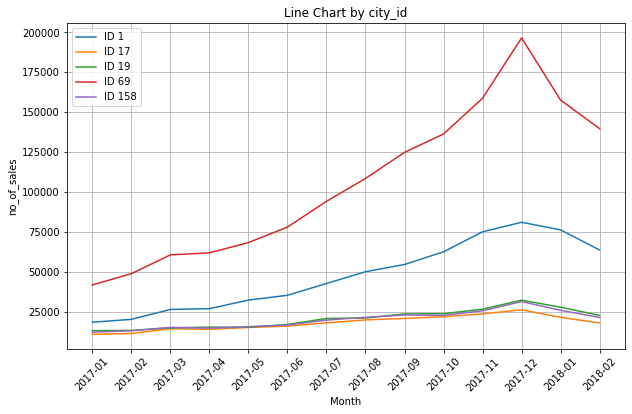

In [0]:
# to make plot out of these results, we need to convert spark dataframe to pandas dataframe and use matplotlib for plotting

# First we plot number of sales
top_cities_pd_df = top_cities_df.toPandas()
# Plot the line chart
plt.figure(figsize=(10, 6))
for key, grp in top_cities_pd_df.groupby(['city_id']):
    plt.plot(grp['Month'], grp['no_of_sales'], label=f'ID {key}')

plt.xlabel('Month')
plt.ylabel('no_of_sales')
plt.title('Line Chart by city_id')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

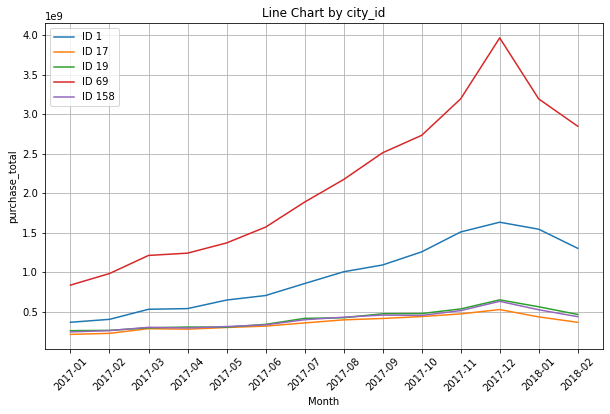

In [0]:
# Now we plot total purchase amounts

# Plot the line chart
plt.figure(figsize=(10, 6))
for key, grp in top_cities_pd_df.groupby(['city_id']):
    plt.plot(grp['Month'], grp['purchase_total'], label=f'ID {key}')

plt.xlabel('Month')
plt.ylabel('purchase_total')
plt.title('Line Chart by city_id')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

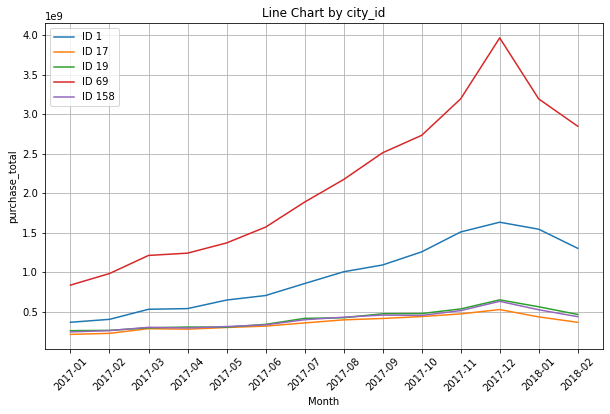

In [0]:
# Now we plot total purchase anounts through time

# Plot the line chart
plt.figure(figsize=(10, 6))
for key, grp in top_cities_pd_df.groupby(['city_id']):
    plt.plot(grp['Month'], grp['purchase_total'], label=f'ID {key}')

plt.xlabel('Month')
plt.ylabel('purchase_total')
plt.title('Line Chart by city_id')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [0]:
# We observe that both in terms of number of sales and value of total sales, we have increase staring from 2017 till the year end. In 2018 we observe that sales start to decline in all sugested cities.

### d) What hours would you recommend they open and close for the day?

In [0]:
# If we assume that merchant is going to the suggested top 5 cities, let's examine the average number of sales in these cities per each hour

top_cities_df_with_hour = task_1_df.filter(col("city_id").isin([69, 1, 19, 158, 17]))

top_cities_df_with_hour = top_cities_df_with_hour.withColumn("hour", hour(col("purchase_date")))

top_cities_df_with_hour = top_cities_df_with_hour.groupBy("city_id","hour").agg(
    spark_count("merchant_name").alias("no_of_sales") 
)

top_cities_df_with_hour = top_cities_df_with_hour.orderBy(col("hour").asc())
top_cities_df_with_hour.show()

+-------+----+-----------+
|city_id|hour|no_of_sales|
+-------+----+-----------+
|     17|   0|      11083|
|     19|   0|      12582|
|    158|   0|      13210|
|     69|   0|      59134|
|      1|   0|      27655|
|      1|   1|      15280|
|     17|   1|       2431|
|     19|   1|       1930|
|     69|   1|      19275|
|    158|   1|       2632|
|    158|   2|       1949|
|     17|   2|       1585|
|      1|   2|      10326|
|     69|   2|      12881|
|     19|   2|       1447|
|    158|   3|       1284|
|     69|   3|       8318|
|     17|   3|        866|
|      1|   3|       8511|
|     19|   3|        811|
+-------+----+-----------+
only showing top 20 rows



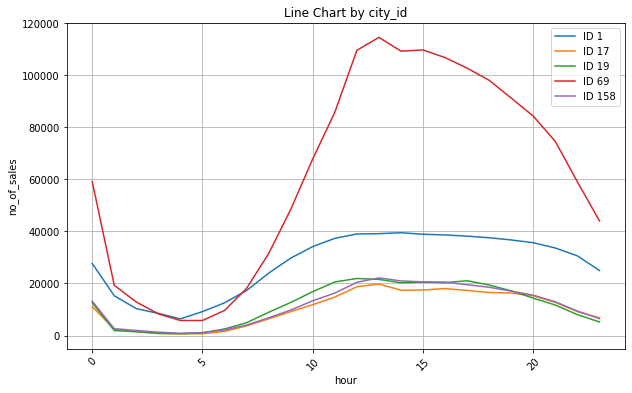

In [0]:
# Now we plot number of purchases per hour for each top city

top_cities_pd_df_with_hour = top_cities_df_with_hour.toPandas()

# Plot the line chart
plt.figure(figsize=(10, 6))
for key, grp in top_cities_pd_df_with_hour.groupby(['city_id']):
    plt.plot(grp['hour'], grp['no_of_sales'], label=f'ID {key}')

plt.xlabel('hour')
plt.ylabel('no_of_sales')
plt.title('Line Chart by city_id')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [0]:
# Based on hour, we observe that most of the sales in all top cities are done between 10 and 20. In hours before and after, we observe decent number of purchases but at these periods are not at day's peak.
# For Open hour I would suggest around 8 and to close around 22. That way we will capture most of the sales.

### e) Would you recommend accepting payments in installments? Assume a credit default
rate of 22.9% per month.


In [0]:
# For this question, consider the “installments” header in the historical transactions and the
# impact it may have, if any, on merchant sales (merchant sales in terms of
# purchase_amounts). We are making a simplistic assumption that 25% of sales is gross
# profit to merchants, there are equal installments and everyone who defaulted did so after
# making half payment.

In [0]:
# Still, If we assume that merchant is going to the suggested top 5 cities, let's examine the loan default impact has on gross profit of each transaction
task_5e_df = historical_transactions.join(merchants, on="merchant_id", how="left").select(
    historical_transactions["city_id"],
    historical_transactions["purchase_amount"],
    historical_transactions["installments"]).filter(col("city_id").isin([69, 1, 19, 158, 17]))

task_5e_df = task_5e_df.withColumn("installment_amount", col("purchase_amount") / col("installments"))
task_5e_df = task_5e_df.withColumn("pd", lit(0.229)) # pd (probability of default) - given in a task description
task_5e_df = task_5e_df.withColumn("lgd", lit(0.5)) # lgd (loss given default) - given in a task description - because default occurs after half payment
task_5e_df = task_5e_df.withColumn("gross_profit_before_losses", col("purchase_amount") * 0.25) # gross profit before credit losses.
task_5e_df = task_5e_df.withColumn("expected_loss", col("installments") * col("installment_amount") * col("pd") * col("lgd"))
task_5e_df = task_5e_df.fillna({'expected_loss': 0}) # zero installments means that a client does not take any credit, so for such cases we will 0
task_5e_df = task_5e_df.withColumn("expected_gross_profit", col("gross_profit_before_losses") - col("expected_loss")) # gross profit before credit losses.
task_5e_df = task_5e_df.withColumn("loss_percentage", col("expected_loss") / col("gross_profit_before_losses")) # gross profit before credit losses.

task_5e_df.show()

+-------+---------------+------------+------------------+-----+---+--------------------------+------------------+---------------------+-------------------+
|city_id|purchase_amount|installments|installment_amount|   pd|lgd|gross_profit_before_losses|     expected_loss|expected_gross_profit|    loss_percentage|
+-------+---------------+------------+------------------+-----+---+--------------------------+------------------+---------------------+-------------------+
|     17|       19620.73|           1|          19620.73|0.229|0.5|                 4905.1825|       2246.573585|          2658.608915|              0.458|
|     69|       16221.69|           1|          16221.69|0.229|0.5|                 4055.4225|1857.3835050000002|          2198.038995|              0.458|
|     69|       16221.69|           1|          16221.69|0.229|0.5|                 4055.4225|1857.3835050000002|          2198.038995|              0.458|
|     69|       20608.72|           0|              null|0.229|0

In [0]:
# Now, we sum gross_profit_before_losses, expected_loss, expected_gross_profit for each of the top cities to plot the aggregate impact of credit losses on profit
task_5e_df_1 = task_5e_df.groupBy("city_id").agg(
    spark_sum("gross_profit_before_losses").alias("sum_of_gross_profit_before_losses"), 
    spark_sum("expected_loss").alias("sum_of_expected_loss"),
    spark_sum("expected_gross_profit").alias("sum_of_expected_gross_profit"),
)

task_5e_df_1 = task_5e_df_1.withColumn("loss_percentage", col("sum_of_expected_loss") / col("sum_of_gross_profit_before_losses")) # gross profit before credit losses.

task_5e_df_1.orderBy(col("loss_percentage").desc()).show()

# To conclude, out of top 5 recommended cities as we can see in the table below, credit losses as the share of gross profit is the highest in city 1, then 158, then 69, then 19, then 17

+-------+---------------------------------+--------------------+----------------------------+-------------------+
|city_id|sum_of_gross_profit_before_losses|sum_of_expected_loss|sum_of_expected_gross_profit|    loss_percentage|
+-------+---------------------------------+--------------------+----------------------------+-------------------+
|      1|              3.353143754235318E9| 1.356282817485182E9|        1.9968609367546263E9| 0.4044809638036176|
|    158|             1.4044909313953831E9|2.9530229402238023E8|        1.1091886373732102E9|0.21025574991003532|
|     69|              7.433990320306711E9|1.5218796166185884E9|          5.91211070370083E9|0.20471907428523511|
|     19|             1.4493098756878111E9| 2.751185644132749E8|        1.1741913112748668E9|0.18982728885546962|
|     17|             1.2633670159931965E9|2.3356093215699092E8|         1.029806083836039E9|0.18487179829796085|
+-------+---------------------------------+--------------------+------------------------

## Thank you!